In [15]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from google.colab import files
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# daba_batch 불러오기
uploaded = files.upload()

Saving data_batch_2 to data_batch_2


In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
data = unpickle('data_batch_1')

In [7]:
def load_data(data, labels):
    # 데이터셋의 이미지 개수
    num_images = data.shape[0]

     # (10000, 3072) 형태인 데이터를 (10000, 3, 32, 32) 형태로 변경
    images = np.reshape(data, (num_images, 32, 32, 3), order='F')

    # (10000, 3, 32, 32) 형태의 이미지 데이터를 (10000, 32, 32, 3)로 변경
    images = np.swapaxes(images, 1, 2)
    
    # 레이블과 함께 튜플로 반환
    return images, labels
  

In [25]:
images, lbls = load_data(data[b'data'], data[b'labels'])

# 이미지 데이터 정규화
images = images.astype('float32') / 255.

# 데이터를 학습 및 테스트 세트로 분할 (예: 80%는 학습, 20%는 테스트용)
x_train, x_test, y_train, y_test = train_test_split(images, lbls, test_size=0.2)

# 레이블 범주화
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
def create_cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [23]:
# 모델 생성, 컴파일
model = create_cnn_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True)

# 3번의 연속적인 epoch 동안 개선이 없을 때 학습이 중단되도록 함
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

batch_size = 64
epochs = 50

Epoch 1/50
125/125 [==============================] - 50s 388ms/step - loss: 2.2895 - accuracy: 0.1319 - val_loss: 2.2481 - val_accuracy: 0.1970
Epoch 2/50
125/125 [==============================] - 45s 364ms/step - loss: 2.1066 - accuracy: 0.2153 - val_loss: 1.9783 - val_accuracy: 0.2925
Epoch 3/50
125/125 [==============================] - 46s 365ms/step - loss: 1.9492 - accuracy: 0.2875 - val_loss: 1.8067 - val_accuracy: 0.3565
Epoch 4/50
125/125 [==============================] - 44s 353ms/step - loss: 1.8449 - accuracy: 0.3260 - val_loss: 1.7260 - val_accuracy: 0.3815
Epoch 5/50
125/125 [==============================] - 47s 380ms/step - loss: 1.7849 - accuracy: 0.3478 - val_loss: 1.6840 - val_accuracy: 0.4035
Epoch 6/50
125/125 [==============================] - 45s 359ms/step - loss: 1.7259 - accuracy: 0.3695 - val_loss: 1.6273 - val_accuracy: 0.4005
Epoch 7/50
125/125 [==============================] - 47s 378ms/step - loss: 1.6935 - accuracy: 0.3866 - val_loss: 1.5853 - val_ac

In [ ]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping])
# verbose=1 (progress bar): 각 시대에 대한 진행률 표시줄(progress bar)과 함께 손실 및 정확도와 같은 주요 메트릭을 출력

In [26]:
# 모델 평가
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

63/63 [==============================] - 2s 37ms/step - loss: 1.3311 - accuracy: 0.5225
Test loss: 1.3310656547546387
Test accuracy: 0.5224999785423279


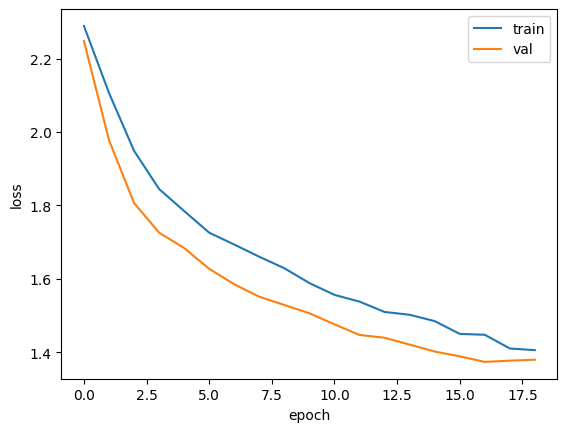

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [29]:
def train_additional_batches(model, filepaths, epochs=10, batch_size=64):
    for filepath in filepaths:
        # 데이터 로드 및 전처리
        with open(filepath, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
        images, lbls = load_data(data[b'data'], data[b'labels'])
        images = images.astype('float32') / 255.
        lbls = np.array(lbls)

        # 모델 학습
        model.fit(images, lbls, epochs=epochs, batch_size=batch_size)
    return model

In [30]:
 # 위의 files.upload()로 다른 data_batch도 불러와야함
 model = train_additional_batches(model, ['data_batch_2'])

Epoch 1/10
157/157 [==============================] - 53s 332ms/step - loss: 1.5074 - accuracy: 0.4566
Epoch 2/10
157/157 [==============================] - 52s 332ms/step - loss: 1.4723 - accuracy: 0.4746
Epoch 3/10
157/157 [==============================] - 52s 331ms/step - loss: 1.4653 - accuracy: 0.4762
Epoch 4/10
157/157 [==============================] - 52s 333ms/step - loss: 1.4365 - accuracy: 0.4906
Epoch 5/10
157/157 [==============================] - 52s 329ms/step - loss: 1.4113 - accuracy: 0.4941
Epoch 6/10
157/157 [==============================] - 53s 335ms/step - loss: 1.4085 - accuracy: 0.4989
Epoch 7/10
157/157 [==============================] - 51s 324ms/step - loss: 1.3791 - accuracy: 0.5148
Epoch 8/10
157/157 [==============================] - 52s 329ms/step - loss: 1.3699 - accuracy: 0.5102
Epoch 9/10
157/157 [==============================] - 52s 330ms/step - loss: 1.3597 - accuracy: 0.5149
Epoch 10/10
157/157 [==============================] - 52s 330ms/step - l

In [31]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

63/63 [==============================] - 3s 45ms/step - loss: 1.2230 - accuracy: 0.5535
Test loss: 1.2229613065719604
Test accuracy: 0.5534999966621399
